In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "planning_budget"
tags = ['2024-03-16-17-36-26']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [3]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 72/72 [00:00<00:00, 217.45it/s]


,Self_Play/Total_Timesteps,grad_steps,Self_Play/Total_Mean_Return,Self_Play/Mean_Timesteps,Self_Play/Min_Timesteps,_runtime,_timestamp,episodes,environment_steps,_step,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,900,76,0.508333,150.000000,150,1310.184315,1.710615e+09,120,10616,19,...,0.3,1,identity,coordinate,0.0001,PolicyPUCT,6,mvc,10,identity
1,897,76,0.408333,149.500000,147,986.561222,1.710614e+09,120,9742,19,...,0.3,1,identity,coordinate,0.0001,PUCT,6,mvc,10,identity
2,742,76,0.358333,123.666667,62,885.160745,1.710614e+09,120,8670,19,...,0.3,1,identity,coordinate,0.0001,PUCT,6,visit,10,identity
3,900,76,0.550000,150.000000,150,288.366543,1.710613e+09,120,9231,19,...,0.3,1,identity,coordinate,0.0001,PolicyPUCT,6,mvc,10,identity
4,900,76,0.475000,150.000000,150,242.005255,1.710613e+09,120,8462,19,...,0.3,1,identity,coordinate,0.0001,PUCT,6,mvc,10,identity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,569,76,30.525000,94.833333,62,208.870838,1.710607e+09,120,3663,19,...,0.3,1,identity,default,0.0001,PUCT,6,visit,10,identity
68,62,76,10.891667,10.333333,9,24.114456,1.710607e+09,120,1307,19,...,0.3,1,identity,default,0.0001,PUCT,6,mvc,10,identity
69,205,76,13.900000,34.166667,17,24.599048,1.710607e+09,120,1668,19,...,0.3,1,identity,default,0.0001,PUCT,6,visit,10,identity
70,879,76,65.725001,146.500000,109,1544.850030,1.710609e+09,120,7887,19,...,0.3,1,identity,default,0.0001,PolicyPUCT,6,mvc,10,identity


In [4]:
df.columns

Index(['Self_Play/Total_Timesteps', 'grad_steps',
       'Self_Play/Total_Mean_Return', 'Self_Play/Mean_Timesteps',
       'Self_Play/Min_Timesteps', '_runtime', '_timestamp', 'episodes',
       'environment_steps', '_step', 'Self_Play/Returns',
       'Self_Play/Timesteps', 'Training/Learning_Rate', 'Self_Play/Min_Return',
       'Self_Play/Cumulative_Return', 'Self_Play/Mean_Return',
       'Self_Play/Discounted_Returns', 'Self_Play/EMA_Return',
       'Training/Value_and_Policy_loss', 'Training/Policy_loss',
       'Training/Regularization_loss', 'Training/Value_loss',
       'Self_Play/Max_Return', 'Self_Play/Entropies', '_wandb',
       'Training/Replay_Buffer_Size', 'Self_Play/Mean_Discounted_Returns',
       'Training/Value_Simularities', 'Self_Play/Mean_Entropy', 'ncols',
       'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha', 'env_params',
       'eval_param', 'hidden_dim', 'iterations', 'model_type', 'norm_layer',
       'dir_epsilon', 'activation_fn', 'learning_rate',

In [5]:
save_folder = 'outfiles'


def name_fn(name):
    # remove "Self_Play/" prefix if it exists
    if name.startswith("Self_Play/"):
        name = name[len("Self_Play/"):]

    # replace slash with underscore
    name = name.replace("/", "_")

    # change underscore to space
    name = name.replace("_", " ")
    return name

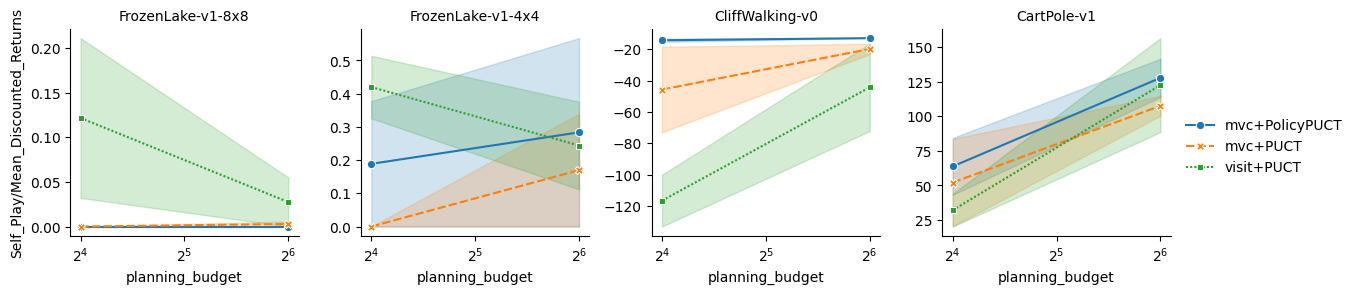

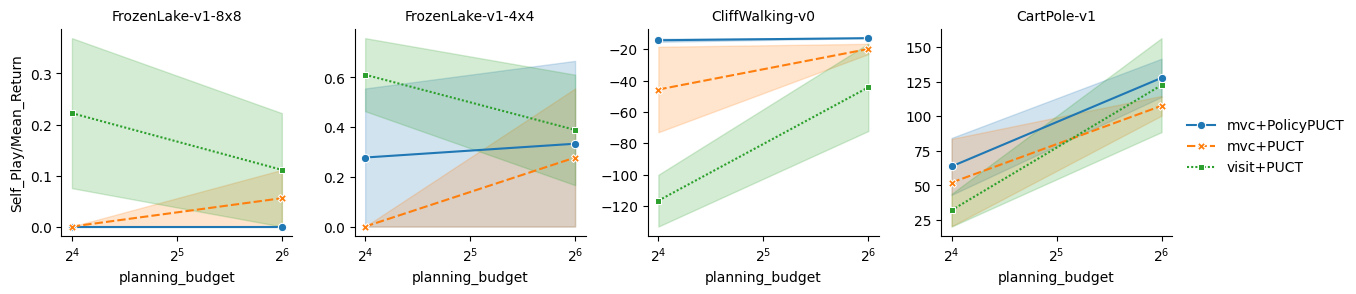

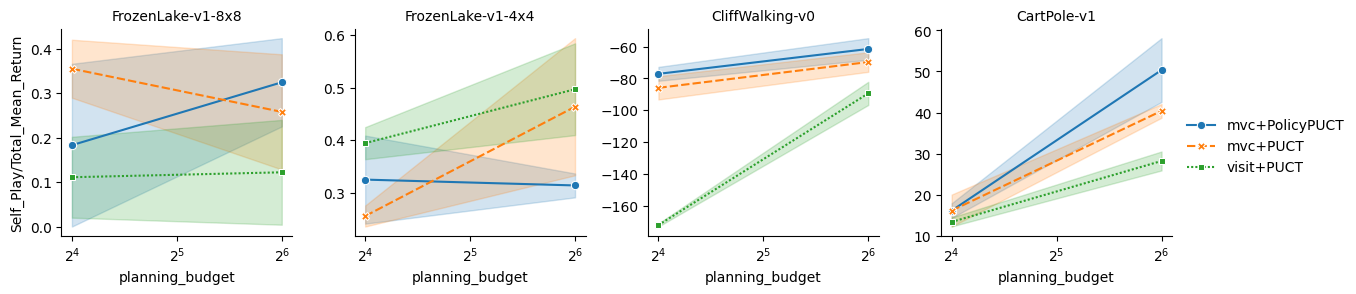

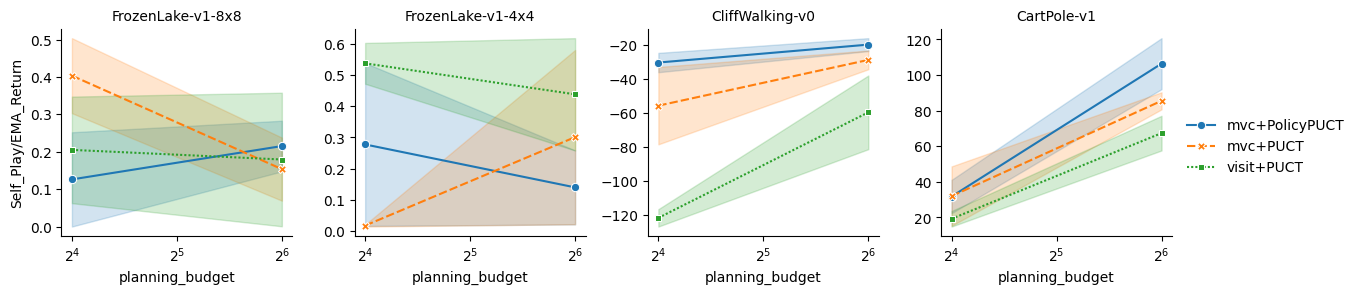

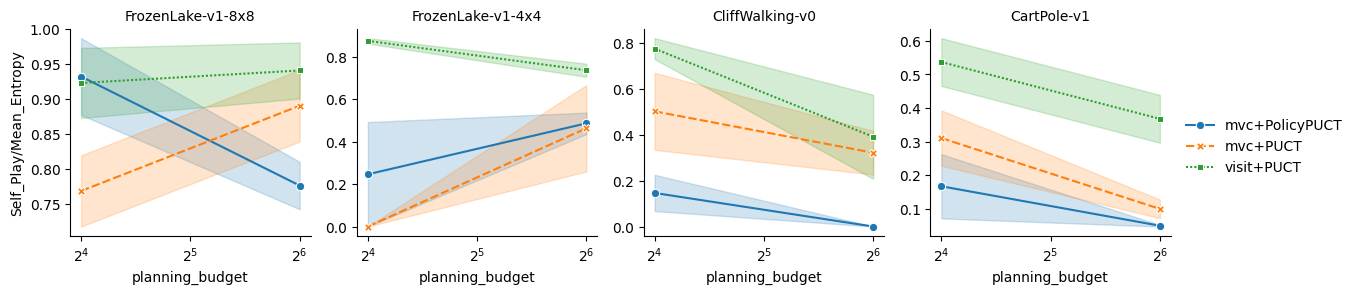

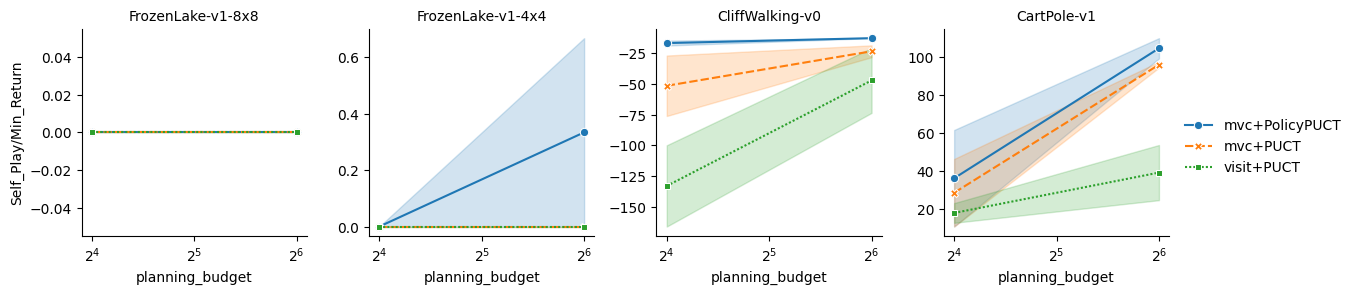

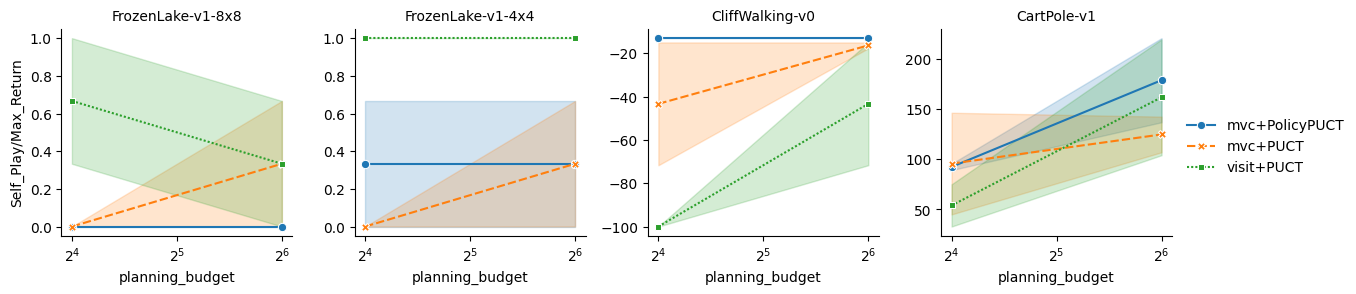

In [8]:


from email.mime import base


df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Discounted_Returns','Self_Play/Mean_Return', "Self_Play/Total_Mean_Return", "Self_Play/EMA_Return", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Return',
           'Self_Play/Max_Return',]


estimator = "mean"
for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(df, col="env_description",sharex=True, sharey=False)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed

    for ax in g.axes.flatten():
        ax.set_xscale('log', base=2)

    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()

    # Set the titles for each subplot for clarity
    g.set_titles("{col_name}")

    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)

    plt.show()